In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
import seaborn as sns
from sklearn import set_config
set_config(display='diagram')
from collections import Counter

%matplotlib inline

#### Prepare the data

In [2]:
# Read the data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Standarize data formats
df.columns = df.columns.str.lower().str.replace(' ','_')
categCols = df.select_dtypes('object').columns.to_list()
for col in categCols:
    df[col] = df[col].str.lower().str.replace(' ','_')
    
# Correct values and type of variable totalcharges
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

# Filling missing values with zero
df.totalcharges.fillna(0, inplace=True)

# Make seniorcitizen an object type variable
df.seniorcitizen = df.seniorcitizen.astype(bool).astype(object)

# Converting the target variable to binary values, no=0 or yes=1.
df.churn = (df.churn == 'yes').astype(int)
df.churn.head()

df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,False,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,False,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,False,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,False,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,False,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


#### Data processing and model

In [3]:
targetCol = 'churn'
target = df[targetCol]
data = df.drop(columns=[targetCol])

In [4]:
# Getting numerical and categorical columns
from sklearn.compose import make_column_selector as selector
numColSelector = selector(dtype_exclude=object)
ctgColSelector = selector(dtype_include=object)
numericalCols = numColSelector(data)
categoricalCols = ctgColSelector(data)
categoricalCols.remove('customerid')

# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")
    #('one-hot-encoder', catPreprocessor, categoricalCols),
    #('standard_scaler', numPreprocessor, numericalCols)])
    
# creating the model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))    

# Splitting the data
from sklearn.model_selection import train_test_split
allColumns = numericalCols + categoricalCols
dataTrainFull, dataTest, targetTrainFull, targetTest = train_test_split(
    data[allColumns], target, test_size=0.2, random_state=1)
dataTrain, dataVal, targetTrain, targetVal = train_test_split(
    dataTrainFull, targetTrainFull, test_size=0.25, random_state=1)
#print(len(dataTrain), len(dataVal), len(dataTest))

In [5]:
_ = model.fit(dataTrain, targetTrain)
acc = round(model.score(dataVal, targetVal),3)
print(f'Accuracy of base model: {acc}')

Accuracy of base model: 0.803


In [6]:
valPred = model.predict_proba(dataVal)[:,1]
valPred

array([0.00775403, 0.2055377 , 0.22004259, ..., 0.14923791, 0.7831508 ,
       0.81251385])

In [7]:
from sklearn.metrics import accuracy_score
binaryPred = model.predict(dataVal)
accuracy_score(targetVal, binaryPred)

0.8034066713981547

In [8]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churnPred = (valPred >= t)
    score = (targetVal == churnPred).mean()
    print(f'Threshold: {t:.2f}, Score: {score:.4f}')
    scores.append(score)

Threshold: 0.00, Score: 0.2740
Threshold: 0.05, Score: 0.5082
Threshold: 0.10, Score: 0.6011
Threshold: 0.15, Score: 0.6636
Threshold: 0.20, Score: 0.7069
Threshold: 0.25, Score: 0.7388
Threshold: 0.30, Score: 0.7601
Threshold: 0.35, Score: 0.7665
Threshold: 0.40, Score: 0.7828
Threshold: 0.45, Score: 0.7942
Threshold: 0.50, Score: 0.8034
Threshold: 0.55, Score: 0.8020
Threshold: 0.60, Score: 0.7977
Threshold: 0.65, Score: 0.7864
Threshold: 0.70, Score: 0.7658
Threshold: 0.75, Score: 0.7431
Threshold: 0.80, Score: 0.7289
Threshold: 0.85, Score: 0.7260
Threshold: 0.90, Score: 0.7260
Threshold: 0.95, Score: 0.7260
Threshold: 1.00, Score: 0.7260


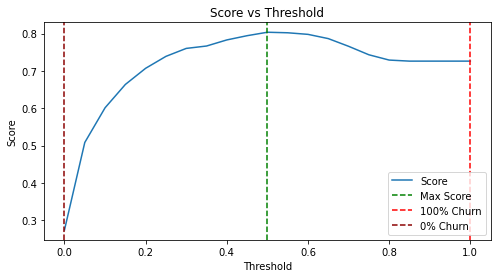

In [9]:
font = {'family': 'serif',
        'color':  'blue',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(thresholds, scores, label='Score')  # Plot some data on the axes.
ax.set_xlabel('Threshold')  # Add an x-label to the axes.
ax.set_ylabel('Score')  # Add a y-label to the axes.
ax.set_title("Score vs Threshold")  # Add a title to the axes.
plt.axvline(x=0.5, linestyle='dashed', color='green', label='Max Score')
plt.axvline(x=1.0, linestyle='dashed', color='red', label='100% Churn')
plt.axvline(x=0, linestyle='dashed', color='darkred', label='0% Churn')

ax.legend();  # Add a legend.
_ = plt.show()

In [10]:
from collections import Counter
count = Counter(targetVal)
for i,j in count.items():
    print(f'target: {i}, count: {j}')
print(f'Target 0 has almost 3 times as much samples as target 1 Total t0/t1 = {round(count[0]/count[1],2)}')
print(f'Total mean of targetVal data is the same as the predicted by dummy predictor'
      f'(when threshold == 1) = {1 - targetVal.mean()}')

target: 0, count: 1023
target: 1, count: 386
Target 0 has almost 3 times as much samples as target 1 Total t0/t1 = 2.65
Total mean of targetVal data is the same as the predicted by dummy predictor(when threshold == 1) = 0.7260468417317246


There is class imbalace in the target values. It's almost 3 to 1. So accuracy here is not a good measure.

#### Confusion table

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

targetValPred = model.predict(dataVal)

920 103 174 212


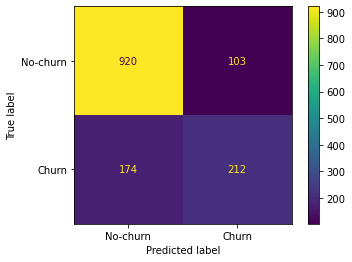

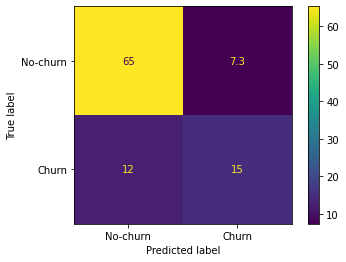

In [12]:
cm = confusion_matrix(targetVal, targetValPred)
cmprob = np.round(100 * cm / len(targetVal), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['No-churn', 'Churn']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['No-churn', 'Churn']).plot()
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

In [13]:
# Another way

threshold = 0.5

actualPos = targetVal == 1
actualNeg = targetVal == 0
predictPos = targetValPred >= threshold
predictNeg = targetValPred < threshold

tp = (actualPos & predictPos).sum()
fp = (predictPos & actualNeg).sum()
tn = (actualNeg & predictNeg).sum()
fn = (actualPos & predictNeg).sum()

confMatrix = np.array([[tn, fp],[fn, tp]])
display('Confusion matrix:', confMatrix)
display('Percentages:', (confMatrix/confMatrix.sum()).round(2))

'Confusion matrix:'

array([[920, 103],
       [174, 212]], dtype=int64)

'Percentages:'

array([[0.65, 0.07],
       [0.12, 0.15]])

#### Precision and Recall

In [14]:
targetValPred2 = (model.predict_proba(dataVal)[0:,1] > 0.5) * 1
#print((targetValPred2 == targetValPred).sum())

# Precision: calculates the part of the predictions that was correct p = tp / (fp + tp)

p = tp / (fp + tp)
print('Precision:',round(p,2))


# Recall: calculates the part of the actual values that was predicted correct r = tp / (tp + fn)

r = tp / (tp + fn)
print('Recall:',round(r,2))

Precision: 0.67
Recall: 0.55


In [15]:
# Another way, with sklearn
print(classification_report(targetVal, targetValPred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1023
           1       0.67      0.55      0.60       386

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.79      0.80      0.80      1409



#### ROC Curves

In [16]:
tpr = tp / (tp + fn)
print('tpr =',tpr)

fpr = fp / (fp + tn)
print('fpr =',fpr)

tpr = 0.5492227979274611
fpr = 0.10068426197458455


In [17]:
def TPR_FPR(targetValPredProba, targetVal):
    thresholds = np.linspace(0, 1, 101)
    scores = []
    for t in thresholds:
        actualPos = (targetVal == 1)
        actualNeg = (targetVal == 0)
        predictPos = (targetValPredProba >= t)
        predictNeg = (targetValPredProba < t)
        #print(t, actualPos.sum(), actualNeg.sum(), predictPos.sum(), predictNeg.sum())
        tp = (actualPos & predictPos).sum()
        tn = (actualNeg & predictNeg).sum()
        
        fp = (predictPos & actualNeg).sum()
        fn = (actualPos & predictNeg).sum()
        
        scores.append((t, tp, fp, fn, tn))
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    dfScores = pd.DataFrame(scores, columns=columns)
    
    dfScores['tpr'] = dfScores.tp / (dfScores.tp + dfScores.fn)
    dfScores['fpr'] = dfScores.fp / (dfScores.fp + dfScores.tn)
    return dfScores

In [18]:
targetValPredProba = model.predict_proba(dataVal)[0:,1]
dfScores = TPR_FPR(targetValPredProba, targetVal)
dfScores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,907,1,116,0.997409,0.886608
2,0.02,384,809,2,214,0.994819,0.790811
3,0.03,382,755,4,268,0.989637,0.738025
4,0.04,381,713,5,310,0.987047,0.696970
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


In [19]:
def plotRates(dfs, names):
    
    plt.figure(figsize=(10,6))
    for df,name in zip(dfs,names):
        plt.plot(df.threshold, df.tpr, label='TPR_' + name)
        plt.plot(df.threshold, df.fpr, label='FPR_' + name)
        plt.legend()
    _ = plt.show()

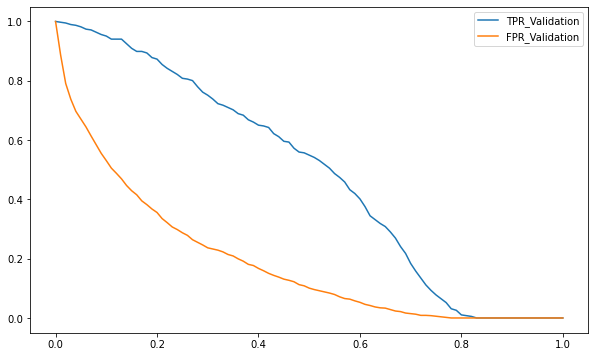

In [20]:
plotRates([dfScores],['Validation'])

#### Random Model

In [21]:
np.random.seed(1)
targetRand = np.random.uniform(0,1,size=len(targetVal))

display(((targetRand >= 0.5) == targetVal).mean())

dfRand = TPR_FPR(targetRand, targetVal)
display(dfRand[::10])

0.5017743080198722

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


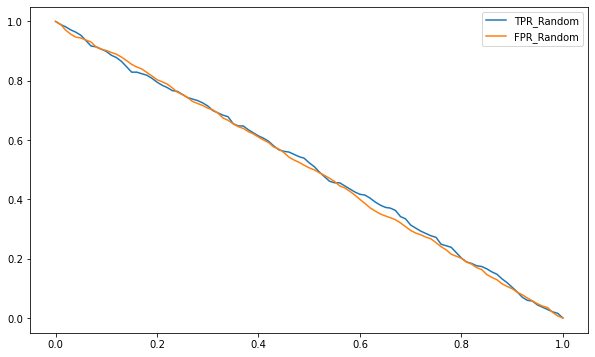

In [22]:
plotRates([dfRand],['Random'])

#### Ideal Model

In [23]:
numNeg, numPos = Counter((targetVal)).values()

targetIdeal = np.repeat([0,1], [numNeg, numPos])

targetIdealPred = np.linspace(0, 1, len(targetVal))
((targetIdealPred >= 0.726) == targetIdeal).mean()

dfIdeal = TPR_FPR(targetIdealPred, targetIdeal)

dfIdeal[::20]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
20,0.2,386,741,0,282,1.000000,0.724340
40,0.4,386,459,0,564,1.000000,0.448680
60,0.6,386,178,0,845,1.000000,0.173998
80,0.8,282,0,104,1023,0.730570,0.000000
100,1.0,1,0,385,1023,0.002591,0.000000


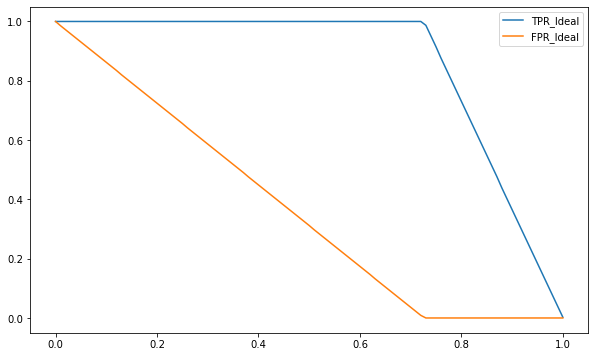

In [24]:
plotRates([dfIdeal],['Ideal'])

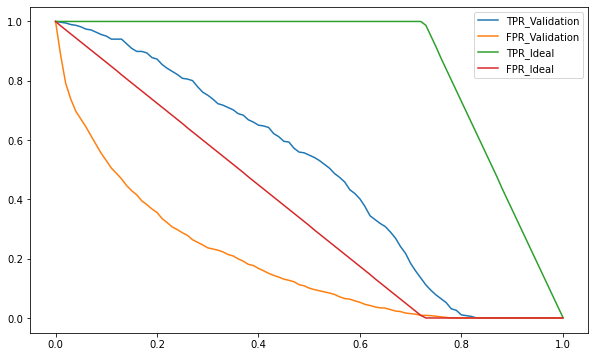

In [25]:
plotRates([dfScores, dfIdeal],['Validation', 'Ideal'])

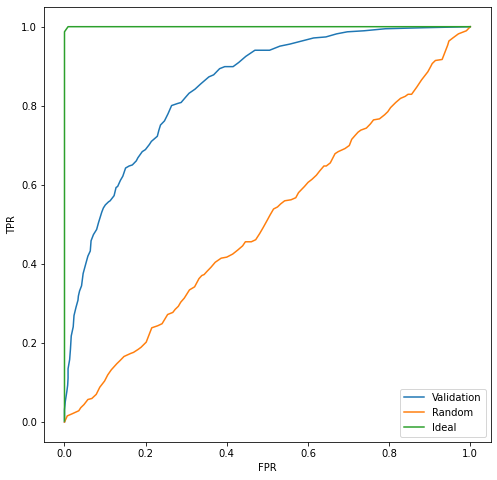

In [26]:
plt.figure(figsize=(8,8))
plt.plot(dfScores.fpr, dfScores.tpr, label='Validation')
plt.plot(dfRand.fpr, dfRand.tpr, label = 'Random')
plt.plot(dfIdeal.fpr, dfIdeal.tpr, label = 'Ideal')

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

_ = plt.show()

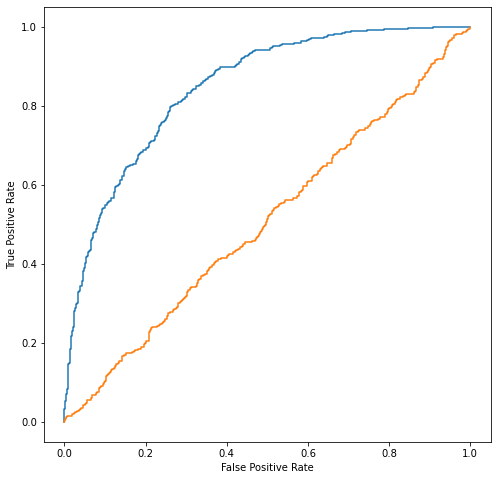

In [27]:
from sklearn.metrics import roc_curve, RocCurveDisplay

#y_score = clf.decision_function(X_test)

fig, ax = plt.subplots(figsize=(8, 8))
fpr, tpr, _ = roc_curve(targetVal.values, targetValPredProba)
roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
fpr2, tpr2, _ = roc_curve(targetVal, targetRand)
roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax)

plt.show()

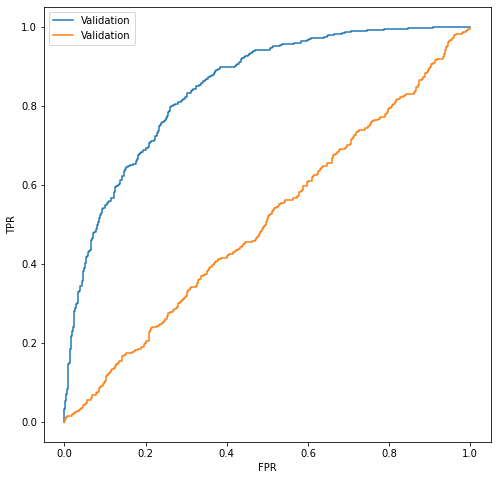

In [28]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='Validation')
plt.plot(fpr2, tpr2, label='Validation')

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

_ = plt.show()

#### AUC - Area Under the ROC Curve

In [29]:
from sklearn.metrics import auc, roc_auc_score

In [30]:
print(f'Sklearn method #1 {auc(fpr, tpr)}')
print(f'Sklearn method #2 {roc_auc_score(targetVal, targetValPredProba)}')
print(f'Sklearn method #3 {auc(dfScores.fpr, dfScores.tpr)}')
print(f'Random model {auc(dfRand.fpr, dfRand.tpr)}')
print(f'Ideal model {auc(dfIdeal.fpr, dfIdeal.tpr)}')

Sklearn method #1 0.8459422910367254
Sklearn method #2 0.8459422910367254
Sklearn method #3 0.8456434645637387
Random model 0.5060233793728696
Ideal model 0.9999430203759136


In [31]:
# Interpretation or AUC
import random
result = 0
neg = targetValPredProba[targetVal == 0]
pos = targetValPredProba[targetVal == 1]

n = 100000

for i in range(n):
    posidx = random.randint(0, len(pos) - 1)
    negidx = random.randint(0, len(neg) - 1)
    
    if pos[posidx] > neg[negidx]:
        result += 1

result / n        

0.84545

In [32]:
# Probability that from two values chosen at random the true-positive one is bigger that the false-positive one
n= 50000
np.random.seed(1)
pos_idx = np.random.randint(0, len(pos), size=n)
neg_idx = np.random.randint(0, len(neg), size=n)
(pos[pos_idx] > neg[neg_idx]).mean()

0.8483

#### K-Fold Cross-validation

In [33]:
from sklearn.feature_extraction import DictVectorizer

In [34]:

def train(df_train, y_train, C=1.0):
    dicts = df_train[categoricalCols + numericalCols].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [35]:
def predict(df, dv, model):
    dicts = df[categoricalCols + numericalCols].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [36]:
newDataTrainFull = dataTrainFull.copy()
newDataTrainFull['churn'] = targetTrainFull.values

In [37]:
# Testing different regularization parameters and doing k-fold cross-validation

from tqdm.auto import tqdm
from sklearn.model_selection import KFold

n_splits = 5

for C in tqdm([1e-3, 1e-2, 0.1, 0.5, 1, 5, 10]):
    
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state=1)   
    ausc = []
    
    for train_idx, val_idx in kfold.split(newDataTrainFull):
        df_train = newDataTrainFull.iloc[train_idx]
        df_val = newDataTrainFull.iloc[val_idx]
        y_train = df_train.churn.values
        y_val = df_val.churn.values
       
        dv, model = train(df_train[categoricalCols + numericalCols], y_train, C=C)
        newTargetPredict = predict(df_val[categoricalCols + numericalCols], dv, model)
        
        auc = roc_auc_score(df_val.churn, newTargetPredict)
        
        ausc.append(auc)       
        
    print('C = %s - Mean AUC = %.3f +- %.3f' % (C, np.mean(ausc), np.std(ausc)))


  0%|          | 0/7 [00:00<?, ?it/s]

C = 0.001 - Mean AUC = 0.825 +- 0.009
C = 0.01 - Mean AUC = 0.840 +- 0.009
C = 0.1 - Mean AUC = 0.840 +- 0.008
C = 0.5 - Mean AUC = 0.840 +- 0.006
C = 1 - Mean AUC = 0.840 +- 0.008
C = 5 - Mean AUC = 0.842 +- 0.008
C = 10 - Mean AUC = 0.841 +- 0.008


In [38]:
dv, model = train(newDataTrainFull[categoricalCols + numericalCols], newDataTrainFull.churn.values, C=1.0)
targetTestPredict = predict(dataTest[categoricalCols + numericalCols], dv, model)

auc = roc_auc_score(targetTest, targetTestPredict)
auc

0.8572386167896259